### Ridge Regression Demand Forecasting Project

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# === 1. Load dataset ===
df = pd.read_csv("sales_data.csv")

# === 2. Convert Date ===
df['Date'] = pd.to_datetime(df['Date'])

#### Unique Time Series Identification

Each time series is uniquely identified by a combination of **Store ID** and **Product ID**.

This is necessary because the dataset includes multiple products across multiple stores, as shown below:

| Store ID | Product ID |
|----------|------------|
| S001     | P0001      |
| S001     | P0002      |
| S002     | P0001      |
| S002     | P0002      |

Each row represents a distinct product-store combination, which forms a separate time series.

In [6]:
# === 3. Create composite ID ===
df['Store_Product_ID'] = df['Store ID'].astype(str) + '_' + df['Product ID'].astype(str)

#### Ensures lag and rolling computations are applied in time order within each product-store.

In [7]:
# === 4. Sort for lag features ===
df = df.sort_values(by=['Store_Product_ID', 'Date'])

#### Creates historical features (lags) and 7-day/14-day rolling averages to capture trends and seasonality.

In [8]:
# === 5. Lag and rolling features ===
df['Lag_1_Demand'] = df.groupby('Store_Product_ID')['Demand'].shift(1)
df['Lag_2_Demand'] = df.groupby('Store_Product_ID')['Demand'].shift(2)
df['Lag_3_Demand'] = df.groupby('Store_Product_ID')['Demand'].shift(3)
df['Rolling_7_Demand'] = df.groupby('Store_Product_ID')['Demand'].shift(1).rolling(window=7).mean()
df['Rolling_14_Demand'] = df.groupby('Store_Product_ID')['Demand'].shift(1).rolling(window=14).mean()

#### Binary features that help the model learn from supply-demand imbalances.

In [9]:
# === 6. Backorder and stockout risk ===
df['Backorder'] = (df['Units Ordered'] > df['Units Sold']).astype(int)
df['Stockout_Risk'] = (df['Inventory Level'] < df['Units Ordered']).astype(int)

#### Extracts time-based signals, including cyclical patterns like seasonal sinusoids for DayOfYear.

In [10]:
# === 7. Date features + seasonality ===
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['Weekday'] = df['Date'].dt.weekday
df['Quarter'] = df['Date'].dt.quarter
df['DayOfYear'] = df['Date'].dt.dayofyear
df['Is_Weekend'] = df['Weekday'].isin([5, 6]).astype(int)
df['Sin_DayOfYear'] = np.sin(2 * np.pi * df['DayOfYear'] / 365)
df['Cos_DayOfYear'] = np.cos(2 * np.pi * df['DayOfYear'] / 365)

#### Transforms regions, weather, category, and seasonality into numeric columns the model can use.

In [11]:
# === 8. Encode categoricals ===
df = pd.get_dummies(df, columns=['Region', 'Weather Condition', 'Seasonality', 'Category'], drop_first=True)

#### Combines features that interact logically

In [12]:
# === 9. Feature interactions ===
df['Price_Discount'] = df['Price'] * df['Discount']
df['Price_vs_Competitor'] = df['Price'] - df['Competitor Pricing']
df['Promo_Discount'] = df['Promotion'] * df['Discount']

#### Removes rows with missing values after lagging and rolling.

In [13]:
# === 10. Drop rows with NaNs ===
print(f"The number of rows before dropping rows with NaNs : {len(df)}")
df.dropna(inplace=True)
print(f"The number of rows after dropping rows with NaNs : {len(df)}")

The number of rows before dropping rows with NaNs : 76000
The number of rows after dropping rows with NaNs : 74600


#### Demand Standardization Within Each Time Series

This part of the code:

```python
df['Demand_scaled'] = df.groupby('Store_Product_ID')['Demand'].transform(
    lambda x: (x - x.mean()) / x.std()
)
```

is standardizing the demand within each `Store_Product_ID` group.

For each unique combination of store and product (e.g., `"S001_P0001"`), it applies the following transformation to the `Demand` values:

```
Demand_scaled = (Demand - mean) / std_deviation
```

Where:

- `m` is the **mean** demand for that `Store_Product_ID`
- `s` is the **standard deviation** of demand for that `Store_Product_ID`

---

##### Why This is Done

There are three key reasons for this standardization:

---

##### 1. Fair Comparison Across Groups

- Each `Store_Product_ID` can have very different sales volumes.
- A high-volume combination (e.g., `S001_P0001`) might have an average demand of 500, while a low-volume one (e.g., `S003_P0009`) might average 5.
- **Standardization ensures** the model learns **patterns**, not just magnitudes.

---

##### 2. Better Model Convergence

- Machine learning algorithms (especially those using gradient-based optimization like Ridge Regression) work better when features are on **similar scales**.
- Standardizing the target:
  - Helps the model converge **faster**
  - Prevents bias toward **large-valued outputs**

---

##### 3. Prevent Data Leakage

- Grouping by `Store_Product_ID` ensures that **no information leaks across different time series** (i.e., between store-product combinations).
- This is especially important in **time-series forecasting**.

---

##### Reversing the Standardization

Later, the standardized predictions are converted back to actual demand values:

```python
preds_df['y_pred'] = preds_df['y_pred_scaled'] * stdevs + means
```

- This transforms the model's predicted standardized demand (`y_pred_scaled`) back to actual demand units using the **group-specific mean and standard deviation**.

---

##### Summary

This line below

- Scales demand to **zero mean and unit variance** within each time series (`Store_Product_ID`)
- Stabilizes training and enables the model to learn **relative patterns** more effectively
- Then unscales predictions to retrieve the **actual demand numbers**

In [14]:
# === 11. Normalize demand by composite ID ===
df['Demand_scaled'] = df.groupby('Store_Product_ID')['Demand'].transform(
    lambda x: (x - x.mean()) / x.std()
)

#### Sets target (y) and predictors (X) for training.

In [15]:
# === 12. Set target and features ===
y = df['Demand_scaled']

feature_cols = [
    'Price', 'Discount', 'Competitor Pricing', 'Promotion', 'Inventory Level',
    'Units Ordered', 'Month', 'Day', 'Weekday', 'Quarter', 'DayOfYear', 'Is_Weekend',
    'Sin_DayOfYear', 'Cos_DayOfYear', 'Backorder', 'Stockout_Risk', 'Epidemic',
    'Lag_1_Demand', 'Lag_2_Demand', 'Lag_3_Demand', 'Rolling_7_Demand', 'Rolling_14_Demand',
    'Price_Discount', 'Price_vs_Competitor', 'Promo_Discount'
]

feature_cols += [col for col in df.columns if
                 col.startswith('Region_') or
                 col.startswith('Weather Condition_') or
                 col.startswith('Seasonality_') or
                 col.startswith('Category_')]

X = df[feature_cols]

#### TimeSeriesSplit

- This sets up time-aware cross-validation.
- Instead of randomly shuffling data, TimeSeriesSplit ensures that training data always precedes test data, which is crucial in time series forecasting.
- With n_splits=5, it creates 5 train/test splits that respect time order.

In [16]:
# === 13. TimeSeriesSplit ===
tscv = TimeSeriesSplit(n_splits=5)

#### RidgeCV Pipeline

1. ('poly', PolynomialFeatures(degree=2, include_bias=False))

- Expands your input features to include polynomial terms up to degree 2.
- If your features are [x1, x2], it adds terms like [x1², x2², x1*x2].
- include_bias=False avoids adding a column of ones.

2. ('scaler', StandardScaler())

- Standardizes features (zero mean, unit variance), which is important for regularized models like Ridge.

3. ('ridge', RidgeCV(alphas=[0.001, 0.01, 0.1, 1.0, 10.0], scoring='r2', cv=tscv))

- Trains a Ridge Regression model.
- Uses cross-validation to find the best alpha (regularization strength) from the list [0.001, 0.01, 0.1, 1.0, 10.0].
- scoring='r2' means it selects the alpha that gives the best R² score.
- cv=tscv uses the TimeSeriesSplit defined earlier.

In [17]:
# === 14. RidgeCV Pipeline ===
pipeline = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', StandardScaler()),
    ('ridge', RidgeCV(alphas=[0.001, 0.01, 0.1, 1.0, 10.0], scoring='r2', cv=tscv))
])

# === Trains the full pipeline with cross-validated Ridge regression.
pipeline.fit(X, y)

,steps,"[('poly', ...), ('scaler', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,degree,2
,interaction_only,False
,include_bias,False
,order,'C'
,copy,True
,with_mean,True
,with_std,True


#### Gets predictions, then reverts them from scaled units back to actual demand values.

In [18]:
# === 15. Prediction ===
y_pred_scaled = pipeline.predict(X)

##### Inverse Scale Predictions
- `preds_df`: a new DataFrame to hold actual and predicted values.
- `means` and `stdevs`: calculated per `Store_Product_ID`, used to reverse standardization.
- `y_pred`: transforms `y_pred_scaled` back to original demand scale using:

$$
y_{pred} = y_{pred\_scaled} \times \sigma + \mu
$$

In [19]:
# === 16. Inverse scale back to original demand ===
preds_df = df[['Store_Product_ID', 'Demand', 'Date']].copy()
preds_df['y_pred_scaled'] = y_pred_scaled

means = df.groupby('Store_Product_ID')['Demand'].transform('mean')
stdevs = df.groupby('Store_Product_ID')['Demand'].transform('std')

preds_df['y_pred'] = preds_df['y_pred_scaled'] * stdevs + means



##### Add 95% Prediction Interval
- `residual_std`: standard deviation of the residuals (actual - predicted).
- Assumes residuals are normally distributed.
- Adds upper and lower bounds covering ~95% of expected variation:

$$
y_{upper} = y_{pred} + 1.96 \cdot \sigma
$$
$$
y_{lower} = y_{pred} - 1.96 \cdot \sigma
$$

In [ ]:
# === Add 95% prediction interval ===
# === Uses standard deviation of residuals to create a confidence band (±1.96σ covers ~95%).
residual_std = (preds_df['Demand'] - preds_df['y_pred']).std()
preds_df['y_upper'] = preds_df['y_pred'] + 1.96 * residual_std
preds_df['y_lower'] = preds_df['y_pred'] - 1.96 * residual_std

#### Evaluation

In [20]:
# === 17. Evaluation ===
r2 = r2_score(preds_df['Demand'], preds_df['y_pred'])
mae = mean_absolute_error(preds_df['Demand'], preds_df['y_pred'])
rmse = np.sqrt(mean_squared_error(preds_df['Demand'], preds_df['y_pred']))
actual_std = preds_df['Demand'].std()

print(f"R² Score ( % variance explained ): {r2:.4f}")
print(f"MAE ( average absolute error ): {mae:.4f}")
print(f"RMSE ( error magnitude (in same units as demand) ): {rmse:.4f}")
print(f"Std Dev of Actual Demand: {actual_std:.4f}")
print(f"Std Dev of Residuals: {residual_std:.4f}")

R² Score ( % variance explained ): 0.6806
MAE ( average absolute error ): 20.2389
RMSE ( error magnitude (in same units as demand) ): 26.5680
Std Dev of Actual Demand: 47.0093
Std Dev of Residuals: 26.5682


#### Visual check for bias: residuals should be centered around 0 and evenly spread.

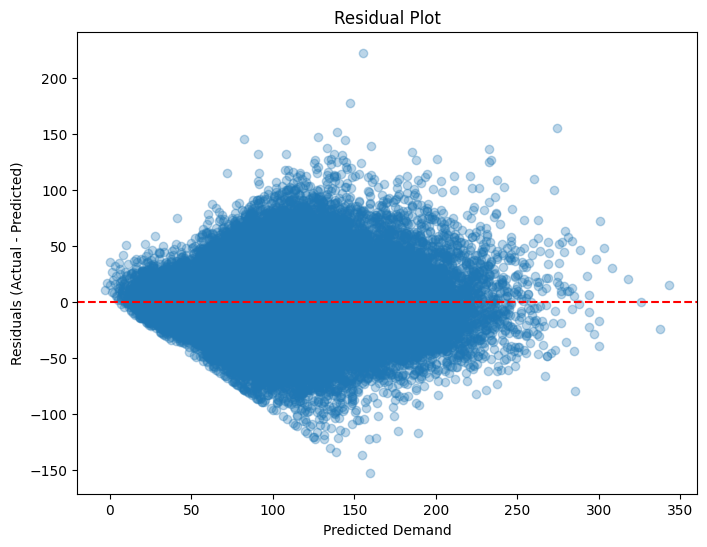

In [21]:
# === 18. Residual Plot ===
plt.figure(figsize=(8,6))
plt.scatter(preds_df['y_pred'], preds_df['Demand'] - preds_df['y_pred'], alpha=0.3)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Demand")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residual Plot")
plt.show()

#### Actual vs Predicted Demand over time
#### Shaded area = 95% prediction interval

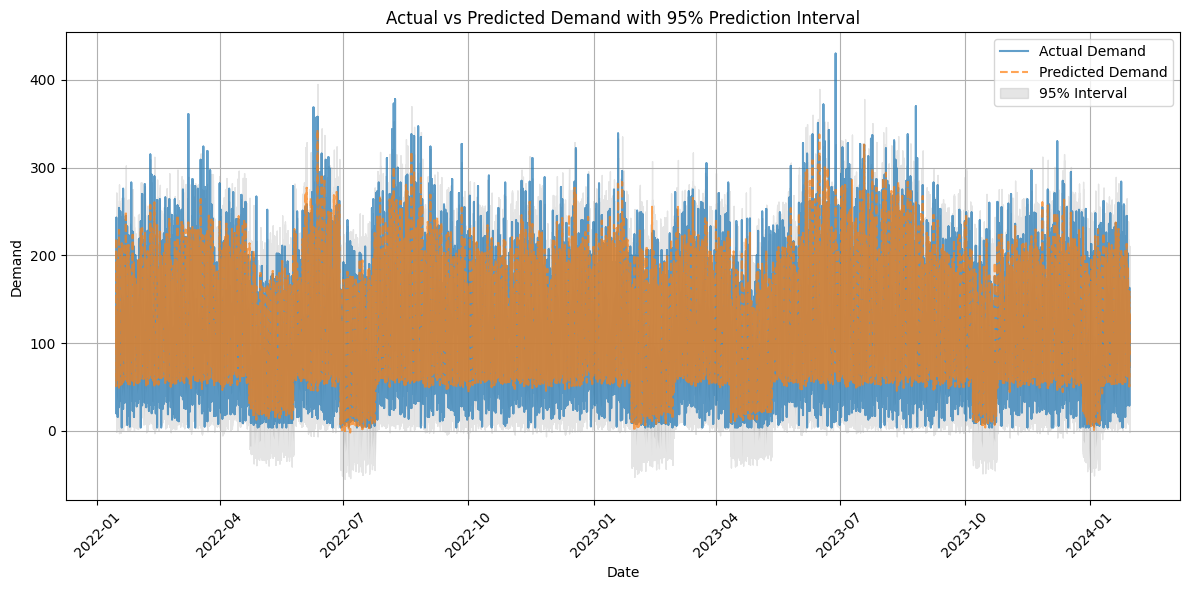

In [22]:
# === 19. Time Series Plot with Prediction Interval ===

preds_df = preds_df.sort_values('Date')

plt.figure(figsize=(12,6))
plt.plot(preds_df['Date'], preds_df['Demand'], label='Actual Demand', alpha=0.7)
plt.plot(preds_df['Date'], preds_df['y_pred'], label='Predicted Demand', linestyle='--', alpha=0.7)
plt.fill_between(preds_df['Date'], preds_df['y_lower'], preds_df['y_upper'], color='gray', alpha=0.2, label='95% Interval')
plt.title("Actual vs Predicted Demand with 95% Prediction Interval")
plt.xlabel("Date")
plt.ylabel("Demand")
plt.legend()
plt.grid(True)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [23]:
# === Summary for Presentation ===
summary = """
📊 MODEL SUMMARY
--------------------------
✅ Model Type: Ridge Regression (Linear)
✅ Forecast Target: Product Demand
✅ Features Used: Price, Inventory, Seasonality, Lags, Promotions, etc.
✅ Polynomial Degree: 2 (to capture feature interactions)
✅ Composite Key: Store ID + Product ID
✅ Normalization: Demand scaled per Product-Store
✅ Validation: TimeSeriesSplit Cross-Validation
✅ Forecast Output: Point estimate + 95% Prediction Interval

📈 METRICS
--------------------------
R² Score: {:.4f}
MAE: {:.2f}
RMSE: {:.2f}
Std Dev of Actual Demand: {:.2f}
Std Dev of Residuals: {:.2f}

💡 INSIGHT
--------------------------
Prediction intervals help estimate inventory risk.
Overestimating → Overstock costs
Underestimating → Stockouts & lost sales
""".format(r2, mae, rmse, actual_std, residual_std)

print(summary)



📊 MODEL SUMMARY
--------------------------
✅ Model Type: Ridge Regression (Linear)
✅ Forecast Target: Product Demand
✅ Features Used: Price, Inventory, Seasonality, Lags, Promotions, etc.
✅ Polynomial Degree: 2 (to capture feature interactions)
✅ Composite Key: Store ID + Product ID
✅ Normalization: Demand scaled per Product-Store
✅ Validation: TimeSeriesSplit Cross-Validation
✅ Forecast Output: Point estimate + 95% Prediction Interval

📈 METRICS
--------------------------
R² Score: 0.6806
MAE: 20.24
RMSE: 26.57
Std Dev of Actual Demand: 47.01
Std Dev of Residuals: 26.57

💡 INSIGHT
--------------------------
Prediction intervals help estimate inventory risk.
Overestimating → Overstock costs
Underestimating → Stockouts & lost sales

